In [3]:
import os
import sys

import pandas as pd
import numpy as np

# import cv2
from glob import glob
from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings("ignore")

### 주어진 정보

- 훈련 데이터 구성
    1. 2700명의 이미지
    2. 한 사람당 `mask1 ~ mask5` 5장, `incorrect_mask` 1장, `normal` 1장 총 7장의 사진으로 구성
    3. 이미지 크기: (384, 512)
    4. 결과값으로 총 18개의 클래스(0 ~ 17)를 분류해야 합니다.
        - 18개의 클래스는 각각의 경우(mask 착용 여부, 성별, 연령)를 모두 곱한 경우 즉, 모든 경우의 수
        - 각 클래스별 세부내용
            - A. Mask 착용 여부 - `Mask` : 0, `Incorrect` : 1, `Not wear` : 2
            - B. 나이 - `< 30` : 0, `>= 30 and < 60` : 1, `>= 60` : 2
            - C. 성별 - `Male` : 0, `Female` : 1

In [2]:
#Path
class ConfigPath:
    data_dir = "../data/train"
    image_dir = f"{data_dir}/images"
    csv_path = f"{data_dir}/train.csv"

In [3]:
train_data = pd.read_csv(ConfigPath.csv_path)
train_data.sample(10)

,id,gender,race,age,path
307,000730,female,Asian,51,000730_female_Asian_51
316,000740,female,Asian,52,000740_female_Asian_52
217,000614,female,Asian,56,000614_female_Asian_56
1313,003332,female,Asian,19,003332_female_Asian_19
1180,003136,female,Asian,19,003136_female_Asian_19
2012,005071,male,Asian,60,005071_male_Asian_60
1095,003031,female,Asian,19,003031_female_Asian_19
732,001464-1,female,Asian,56,001464-1_female_Asian_56
1125,003064,female,Asian,20,003064_female_Asian_20
1355,003382,female,Asian,20,003382_female_Asian_20


#### 결측치 확인

In [4]:
train_data.isna().sum()

id        0
gender    0
race      0
age       0
path      0
dtype: int64

### 훈련 데이터 분포

In [5]:

labels = ["mask1", "mask2", "mask3", "mask4", "mask5"]
label_to_number = {k:0 for k in labels}
label_to_number["incorrect_mask"] = 1
label_to_number["normal"] = 2
label_to_number["male"] = 0
label_to_number["female"] = 1

new_data = []

for idx, image_path in enumerate(train_data.path):
    age = train_data.age[idx]
    gender = train_data.gender[idx]
    
    for image in glob(os.path.join(ConfigPath.image_dir, image_path, "*")):
        temp = [train_data.id[idx], image, age, gender]
        mask = image.split("/")[-1].split(".")[0]
        temp.append(label_to_number[mask])
        temp.append(label_to_number[gender])
        
        if age < 30:
            temp.append(0)
        elif 30 <= age < 60:
            temp.append(1)
        else:
            temp.append(2)
        
        new_data.append(temp)

new_train_data = pd.DataFrame(new_data,
    columns=["id", "path", "age", "gender", "mask_label", "gender_label", "age_label"])
new_train_data.sample(5)

,id,path,age,gender,mask_label,gender_label,age_label
10204,003523,./train/images/003523_male_Asian_59/mask2.jpg,59,male,0,0,1
8068,003102,./train/images/003102_female_Asian_20/normal.jpg,20,female,2,1,0
16597,006258,./train/images/006258_female_Asian_20/incorrec...,20,female,1,1,0
14745,005274,./train/images/005274_male_Asian_20/mask1.jpg,20,male,0,0,0
9238,003343,./train/images/003343_female_Asian_20/mask2.jpg,20,female,0,1,0


In [6]:
# 전체 클래스 열 추가
all_classes = []

for mask, gender, age in zip(new_train_data["mask_label"], new_train_data["gender_label"],\
    new_train_data["age_label"]):
    case = mask*6 + gender*3 + age
    all_classes.append(case)

new_train_data["all_classes"] = all_classes
new_train_data.head()

,id,path,age,gender,mask_label,gender_label,age_label,all_classes
0,000001,./train/images/000001_female_Asian_45/incorrec...,45,female,1,1,1,10
1,000001,./train/images/000001_female_Asian_45/mask4.jpg,45,female,0,1,1,4
2,000001,./train/images/000001_female_Asian_45/mask5.jpg,45,female,0,1,1,4
3,000001,./train/images/000001_female_Asian_45/mask1.jpg,45,female,0,1,1,4
4,000001,./train/images/000001_female_Asian_45/normal.jpg,45,female,2,1,1,16


#### 전체 클래스 분포

In [20]:
def show_total_classes_distribution(x, y, mode="pivot"):
    if mode is not None:
        pivots = [3, 4, 8, 11, 14, 17]
        color = ["red" if i in pivots else "darkgray" for i in range(18)]
    else:
        color = "darkgray"
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 30))
    ax.bar(y, x, color=color, edgecolor="black", linewidth=2)

    for label in range(18):
        ax.text(label, x[label], s=x[label],
                fontweight='bold', ha='center', va="bottom",
                bbox=dict(boxstyle='round,pad=0.3', fc='#1ABDE9', ec='black', alpha=0.3))

    ax.set_xticks(y)
    ax.axes.yaxis.set_ticks(list(range(0,max(x),50)))
    
    plt.ylabel("Number of images")
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    ax.set_title("All classes distribution",
                fontdict={"fontfamily":"serif","fontweight":"bold","fontsize":15})
    plt.show()

In [21]:
data = new_train_data["all_classes"].value_counts().sort_index()
labels = data.index.values
data, labels

(all_classes
 0     2745
 1     2050
 2      415
 3     3660
 4     4085
 5      545
 6      549
 7      410
 8       83
 9      732
 10     817
 11     109
 12     549
 13     410
 14      83
 15     732
 16     817
 17     109
 Name: count, dtype: int64,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]))

In [ ]:
show_total_classes_distribution(data, labels, None)

클래스 불균형이 심해 보인다.
유난히 많거나 적은 데이터를 따로 표시해보자.

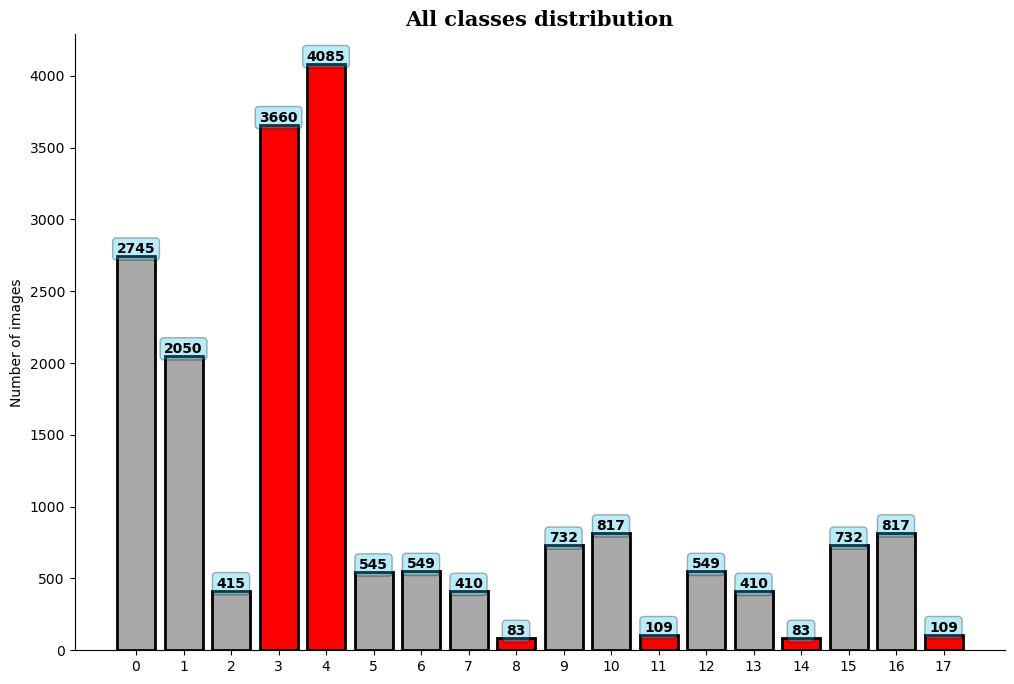

In [116]:
show_total_classes_distribution(data, labels)

#### 마스크 착용 상태 분포

In [150]:
mask_data = new_train_data["mask_label"].value_counts().sort_index()
mask_labels = mask_data.index.values
mask_data, mask_labels

(mask_label
 0    13500
 1     2700
 2     2700
 Name: count, dtype: int64,
 array([0, 1, 2]))

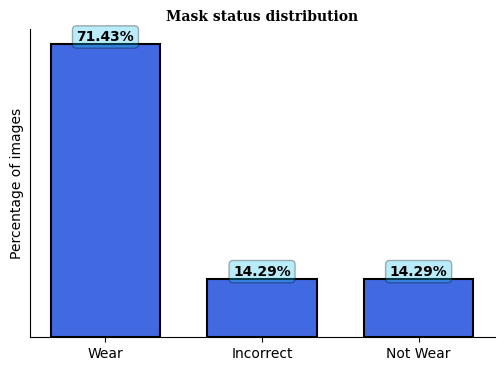

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# barplot
ax.bar(['Wear', 'Incorrect', 'Not Wear'], mask_data,
    color="royalblue", edgecolor="black", linewidth=1.5, width=.7)

# texts
percentage = [f"{i*100:.2f}%" for i in mask_data / mask_data.sum()]
for label in range(3):
    ax.text(label, mask_data[label], s=percentage[label],
            fontweight='bold', ha='center', va="bottom",
            bbox=dict(boxstyle='round,pad=0.3', fc='#1ABDE9', ec='black', alpha=0.3))

# ticks
ax.axes.yaxis.set_ticks([])

# spines
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)

# graph labels
plt.ylabel("Percentage of images")
ax.set_title("Mask status distribution",
            fontdict={"fontfamily":"serif","fontweight":"bold","fontsize":10})
plt.show()

In [7]:
int(8**0.5)

2

In [ ]:
# # max
# ax.plot([-1, np.argmax(data)], [data[np.argmax(data)]]*2,
#         linestyle='--', color='tomato')

# ax.scatter(np.argmax(data), data[np.argmax(data)], 
#         c='tomato',s=50, zorder=20)

# # min
# ax.plot([-1, np.argmin(data)], [data[np.argmin(data)]]*2,
#         linestyle='--', color='royalblue')

# ax.scatter(np.argmin(data), data[np.argmin(data)], 
#         c='royalblue',s=50, zorder=20)

In [5]:
import torch
import numpy as np

a = torch.tensor([[1,2,3],
                  [4,5,6],
                  [7,8,9]])
b = torch.tensor([[1,2,3],
                  [4,5,6],
                  [7,8,9]])

torch.hstack([a, b])

tensor([[1, 2, 3, 1, 2, 3],
        [4, 5, 6, 4, 5, 6],
        [7, 8, 9, 7, 8, 9]])

In [15]:
torch.sum(a + b)

tensor(90)